# Recommenders 3 -- Sequence Recommenders (45m) 

## Goals of this practical:

- Understand the sequence recommendation framework (~5min)
- Load/Format dataset (~5min)
- Understand/train the prod2vec model (~10min)
- Evaluate (~10min)
- Visualize (~10min)
- Fiddle (~5min)



In [1]:
#! pip install gensim --upgrade

In [2]:
import pandas as pd
import numpy as np

# Sequence Recommenders:

> What will you click next ?

The sequence recommendation setting is a particular case of the implicit collaborative filtering setting. Given a sequence of items $i_0,i_1,...,i_n$ the goal is to predict the $i_{(n+1)},...$ items the user will consume. Playlist continuation is a neat use case of sequence recommenders. You've been listening to those songs, what can you listen to now ?


This setting differs from the classical collaborative filtering because the history is the recent trace and not the full saved interactions. Also, it's possible to do sequence recommendation without any specific latent user profile. 

#### Here we propose to explore this unpersonalized sequence recommandation

## Data used : [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/)

Here we'll use the same data as before but instead of seeing $(user,item,rating)$ triplets or a $(user,item)$ interaction , we'll see item sequences: $user: [item, item,...]$

## Loading Data (same as before but in chronological order):

In [3]:
ratings = pd.read_csv("dataset/ratings.csv")
ratings = ratings.sort_values("timestamp",ascending=True)
print(ratings.iloc[0]["timestamp"] < ratings.iloc[-1]["timestamp"] ) # just checking 


# we also load titles and create an id2title dictionnary
titleCSV = pd.read_csv("dataset/movies.csv")
titleCSV.head(5)
id2title = titleCSV[["movieId","title"]].set_index("movieId").to_dict()["title"]

True


In [4]:
ratings.head(5)

,userId,movieId,rating,timestamp
66719,429,595,5.0,828124615
66716,429,588,5.0,828124615
66717,429,590,5.0,828124615
66718,429,592,5.0,828124615
66712,429,432,3.0,828124615


## (a) Create sequence datasets:
For this task, we need sequences of items as data:

## (Todo): extract all movie sequences (in chronological order) from the dataset:


In this dataset, each user has seen at least 20 movies.


- We need to extract all movie rating sequences (there is one per user) from the dataset:

`sequence_of_movies = [[movieid,...],[movieid,...],...]`

In [5]:
sequences_of_movies = [list(ratings[ratings['userId'] == id]['movieId'].values) for id in ratings['userId'].unique()]
#sequences_of_movies = ratings.groupby("userId")["movieId"].apply(list).values


## (Todo): Create a train/test dataset

Here, we propose as task to predict the last 5 items of each sequence.

In [6]:
train_seq,test_seq = [],[]

for seq in sequences_of_movies:
    train_seq.append(seq[:-5])
    test_seq.append(seq[-5:])
    
last_consumed_item = [seq[-1] for seq in train_seq] # We save the last consumed item for each list
                                                    # We'll use it as a starting point

## (Todo): Create the list of the most popular movies

- Here, popular is the number of times the movie appears in a list

In [7]:
from collections import Counter

counts = np.asarray([Counter(seq) for seq in sequences_of_movies]).sum()
most_popular = list(dict(counts.most_common()).keys())
num_items = len(most_popular)

``` python
#Most popular looks like this:
[356,318,296,2571,593,260,480,110,589,...]
 ```

## Word2Vec skip-gram <=> Prod2Vec


### Word2Vec

The MAIN idea of word2vec is to maximise the similarity (dot product) between the vectors for words which appear close together (in the context of each other) in text, and minimise the similarity of words that do not. 

This can be applied to products instead of words: it clusters similar products together.


#### Paper Abstract:
> In recent years online advertising has become increasingly ubiquitous and effective. Advertisements shown to visitors fund sites and apps that publish digital content, manage social networks, and operate e-mail services. Given such large variety of internet resources, determining an appropriate type of advertising for a given platform has become critical to financial success. Native advertisements, namely ads that are similar in look and feel to content, have had great success in news and social feeds. However, to date there has not been a winning formula for ads in e-mail clients. In this paper we describe a system that leverages user purchase history determined from e-mail receipts to deliver highly personalized product ads to Yahoo Mail users. We propose to use a novel neural language-based algorithm specifically tailored for delivering effective product recommendations, which was evaluated against baselines that included showing popular products and products predicted based on co-occurrence. We conducted rigorous offline testing using a large-scale product purchase data set, covering purchases of more than 29 million users from 172 e-commerce websites. Ads in the form of product recommendations were successfully tested on online traffic, where we observed a steady 9% lift in click-through rates over other ad formats in mail, as well as comparable lift in conversion rates. Following successful tests, the system was launched into production during the holiday season of 2014

[Prod2Vec Model](https://arxiv.org/abs/1606.07154)



## Gensim has the best python implementation of word2vec's algorithms:

We can just use these raw implementations. The only thing to do is to consider items as words:

In [8]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)



train_seq_str = [list(map(str,seq)) for seq in train_seq] # we just say that our items id's are strings..
    

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=train_seq_str,
                                size=50, window=10,               ### here we train a cbow model 
                                min_count=0,                      
                                sample=0.001, ns_exponent=0.75, workers=10,
                                sg=1, hs=0, negative=15,          ### set sg to 1 to train a sg model => Prod2Vec
                                cbow_mean=0,
                                iter=50)

2021-03-11 08:48:44,420 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2021-03-11 08:48:44,422 : INFO : collecting all words and their counts
2021-03-11 08:48:44,423 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-11 08:48:44,470 : INFO : collected 9616 word types from a corpus of 97786 raw words and 610 sentences
2021-03-11 08:48:44,472 : INFO : Loading a fresh vocabulary
2021-03-11 08:48:44,552 : INFO : effective_min_count=0 retains 9616 unique words (100% of original 9616, drops 0)
2021-03-11 08:48:44,566 : INFO : effective_min_count=0 leaves 97786 word corpus (100% of original 97786, drops 0)
2021-03-11 08:48:44,697 : INFO : deleting the raw counts dictionary of 9616 items
2021-03-11 08:48:44,699 : INFO : sample=0.001 downsamples 5 most-common words
2021-03-11 08:48:44,700 : INFO : downsampling leaves estimated 97657 word corpus (99.9% of prior 97786)
2021-03-11 08:48:44,754 : INFO : estimated required memory fo

2021-03-11 08:49:04,343 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:49:04,406 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:49:04,408 : INFO : EPOCH - 6 : training on 97786 raw words (97665 effective words) took 2.7s, 36585 effective words/s
2021-03-11 08:49:06,165 : INFO : EPOCH 7 - PROGRESS: at 8.52% examples, 5821 words/s, in_qsize 10, out_qsize 0
2021-03-11 08:49:06,181 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:49:06,200 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:49:06,238 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:49:06,297 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:49:06,593 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:49:06,708 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:49:06,824 : INF

2021-03-11 08:49:21,280 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:49:21,360 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:49:21,363 : INFO : EPOCH - 13 : training on 97786 raw words (97651 effective words) took 2.5s, 39857 effective words/s
2021-03-11 08:49:23,070 : INFO : EPOCH 14 - PROGRESS: at 6.72% examples, 5896 words/s, in_qsize 10, out_qsize 0
2021-03-11 08:49:23,152 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:49:23,180 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:49:23,222 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:49:23,226 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:49:23,527 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:49:23,545 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:49:23,642 : I

2021-03-11 08:49:38,025 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:49:38,029 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:49:38,031 : INFO : EPOCH - 20 : training on 97786 raw words (97676 effective words) took 2.4s, 41547 effective words/s
2021-03-11 08:49:39,622 : INFO : EPOCH 21 - PROGRESS: at 12.46% examples, 5666 words/s, in_qsize 10, out_qsize 0
2021-03-11 08:49:39,659 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:49:39,715 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:49:40,091 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:49:40,131 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:49:40,133 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:49:40,289 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:49:40,301 : 

2021-03-11 08:49:54,508 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:49:54,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:49:54,581 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:49:54,582 : INFO : EPOCH - 27 : training on 97786 raw words (97642 effective words) took 2.2s, 43499 effective words/s
2021-03-11 08:49:55,558 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:49:56,083 : INFO : EPOCH 28 - PROGRESS: at 16.39% examples, 13824 words/s, in_qsize 8, out_qsize 1
2021-03-11 08:49:56,085 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:49:56,275 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:49:56,415 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:49:56,547 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:49:56,692 : 

2021-03-11 08:50:10,624 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:50:10,657 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:50:10,818 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:50:10,872 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:50:10,873 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:50:10,874 : INFO : EPOCH - 34 : training on 97786 raw words (97669 effective words) took 2.3s, 43356 effective words/s
2021-03-11 08:50:12,598 : INFO : EPOCH 35 - PROGRESS: at 6.72% examples, 5815 words/s, in_qsize 10, out_qsize 0
2021-03-11 08:50:12,663 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:50:12,767 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:50:12,944 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:50:12,969 : I

2021-03-11 08:50:26,819 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:50:26,942 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:50:27,071 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:50:27,115 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:50:27,121 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:50:27,124 : INFO : EPOCH - 41 : training on 97786 raw words (97666 effective words) took 2.3s, 42041 effective words/s
2021-03-11 08:50:28,112 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:50:28,374 : INFO : EPOCH 42 - PROGRESS: at 19.34% examples, 16563 words/s, in_qsize 8, out_qsize 1
2021-03-11 08:50:28,377 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:50:28,433 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:50:28,980 : 

2021-03-11 08:50:44,480 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:50:44,513 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:50:44,602 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:50:44,669 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:50:44,718 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:50:44,739 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:50:44,741 : INFO : EPOCH - 48 : training on 97786 raw words (97650 effective words) took 2.5s, 38902 effective words/s
2021-03-11 08:50:45,615 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:50:46,179 : INFO : EPOCH 49 - PROGRESS: at 14.92% examples, 14047 words/s, in_qsize 8, out_qsize 1
2021-03-11 08:50:46,181 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:50:46,406 : 

### A few things:

In [9]:
print(w2v.wv.vectors[0])              # The vector of index 0
print(w2v.wv.index2word[0])           # codes for the movieId 356
print(w2v.wv.vocab["356"].index)      # Inverse mapping


[ 0.39818847 -0.2801535  -0.9501748   0.37598923  1.0202657   0.01552723
 -0.41624027  0.23826908  0.7772566  -0.17907068 -0.43146133 -0.56973624
  0.16038768 -0.06844611  0.24841109  0.07849234 -0.15293169  0.26098186
  0.14971541 -0.2873157  -0.45365134  0.6260886   0.4411372   0.06583415
  0.28972292 -0.36923018  0.02674621  0.05671233  0.14099811 -0.04415927
  0.63872796 -0.12388096 -0.13038674 -0.06470512 -0.6417044  -0.66074425
  0.00873725 -0.13462052 -0.6988504  -0.5773919  -0.3657546   0.04504156
 -0.23187491 -0.693151    0.06972066  0.18085575 -0.01737205  0.02369497
 -0.16956268  0.15821594]
356
0


## Getting similar items:

The heart of the algorithm is in the similar item search. As in word2vec, we simply use cosine distance between items to find "similar items"

### We can search by id's

In [10]:
def get_similar_ids(w2vmodel,iid,num=5):
    
    if str(iid) in w2vmodel.wv.vocab:
        return [int(iid) for iid,_ in w2vmodel.wv.most_similar(str(iid),topn=num)] 
    else:
        return []

get_similar_ids(w2v,last_consumed_item[0],num=5)

2021-03-11 08:50:50,192 : INFO : precomputing L2-norms of word weight vectors


[231, 410, 597, 539, 8626]

### Or by vector

In [11]:
w2v.wv[str(last_consumed_item[0])]

array([ 0.42098597,  0.9805728 , -1.1662945 , -0.21004966,  0.78408533,
        0.35111073, -0.80608237, -0.23535968,  0.88485646, -0.4650796 ,
        0.09413416, -1.3667927 , -0.16069087,  0.11385872,  0.30032724,
        0.26759434, -0.49626958, -0.09098382,  0.14344394, -0.6971733 ,
       -0.5810224 ,  0.3689275 ,  0.4551429 ,  0.17731687,  0.17238082,
        0.13695596,  0.18709296, -0.5817041 , -0.1571545 ,  0.08945272,
        0.63630694,  0.49294955, -0.5400572 ,  0.6066095 , -0.5628607 ,
       -0.25277224,  0.6171728 ,  0.1139388 , -0.92696   , -0.9351617 ,
       -0.43408176,  0.44711164, -0.3646725 , -0.65867513,  0.25452763,
       -0.0017505 , -0.5697385 , -0.3370672 , -0.17869902, -0.6606217 ],
      dtype=float32)

In [12]:
def get_similar_vectors(w2vmodel,vec,num=5):
        return [int(iid) for iid,_ in w2vmodel.wv.most_similar(positive=[vec],topn=num)] 

get_similar_vectors(w2v,w2v.wv[str(last_consumed_item[0])],num=5) # items are strings

[339, 231, 410, 597, 539]

### Let's see if this works

We can query by id

In [13]:
ID = 1
NUM_SIM = 3

print("Movies similar to: ", id2title[ID])
print("")
for x in get_similar_ids(w2v,ID,NUM_SIM):
    print("--> ",id2title[x])

Movies similar to:  Toy Story (1995)

-->  Forrest Gump (1994)
-->  Toy Story 2 (1999)
-->  Aladdin (1992)


We can also query by vector

**NOTE:** the 1st results can be the item(s) you've used to query

In [14]:
ID = 1
NUM_SIM = 4
print("Movies similar to: ", id2title[ID])
print("")
for x in get_similar_vectors(w2v,w2v.wv[str(ID)],NUM_SIM):
    print("--> ",id2title[x])

Movies similar to:  Toy Story (1995)

-->  Toy Story (1995)
-->  Forrest Gump (1994)
-->  Toy Story 2 (1999)
-->  Aladdin (1992)


Our result was the following (for ID = 1 & NUM_SIM = 3)

>Movies similar to:  Toy Story (1995)
>-  Beauty and the Beast (1991)
-   Toy Story 2 (1999)
-   Lion King, The (1994)


Using vectors enables operations like additions to be made

In [15]:
ID1 = 2571
ID2 = 589
NUM_SIM = 10

vec = np.max([w2v.wv[str(ID1)],w2v.wv[str(ID2)]],axis=0)# + w2v.wv[str(318)]

print("Movies similar to: ", id2title[ID1] , "+",  id2title[ID2] )
print("")
for x in get_similar_vectors(w2v,vec ,NUM_SIM):
    print("--> ",id2title[x])

Movies similar to:  Matrix, The (1999) + Terminator 2: Judgment Day (1991)

-->  Matrix, The (1999)
-->  Terminator 2: Judgment Day (1991)
-->  Saving Private Ryan (1998)
-->  Terminator, The (1984)
-->  Star Wars: Episode V - The Empire Strikes Back (1980)
-->  Speed (1994)
-->  Braveheart (1995)
-->  Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
-->  Star Wars: Episode VI - Return of the Jedi (1983)
-->  Fuzz (1972)


Ok, we now have a good base for our sequence recommendation algorithm, let's write something to evaluate our predictions

## (Todo) write a `get_relevance_list(proposed_ids,real_ids)` function:

This function will be used to compare proposed items w/ real items:


- A relevant item is an item which is in the ground truth
- It returns a list which length is the number of proposed items filled of 0's and 1's : 0 means the item is not relevant, 1 means it's relevant.

- get_relevance_list([1,2,3,4],[1,4,5,6]) should returns [1,0,0,1]  because items 1 and 4 are relevant.


In [16]:
def get_relevance_list(proposed_ids,real_ids):
    real_ids = set(real_ids)
    return [1 if x in real_ids else 0 for x in proposed_ids]
get_relevance_list([1,2,3,4],[1,4,5,6]) #returns [1,0,0,1]

[1, 0, 0, 1]

### Let's test our function on our data

In [17]:
get_relevance_list(most_popular[:25],test_seq[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
get_relevance_list(get_similar_ids(w2v,last_consumed_item[0],25),test_seq[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Ok, now, let's write prediction funtions:

- `predict_pop` will recommend the k's most popular items
- `predict_w2v` will recommend the k's most similar items to the last one consumed

#### (TODO) : complete those functions

In [19]:
def predict_pop(last_seen,k):
    return most_popular[:k]

def predict_w2v(last_seen,k):
    return get_similar_ids(w2v,last_seen,k)

#data is list of last_consumed:
def get_predictions(predict_func,data,truth,k=5):
    if k == -1 or k == 0:
        k = num_items
    return [get_relevance_list(predict_func(last_seen,k),will_see) for last_seen,will_see in zip(data,truth)]

**Note**: The `get_predictions(...)` function returns the relevant list associated to predictions

### The following cells should return list of lists

In [20]:
print(get_predictions(predict_pop,last_consumed_item[:5],test_seq[:5],3))
print(get_predictions(predict_w2v,last_consumed_item[:5],test_seq[:5],3))

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0]]


expected output: 
```
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

```

## The return of the MRR and nDCG functions

In [21]:
test_list = [[0,0,1],[0,1,0],[1,0,0],[0,0,0]]

def rr(list_items):
    relevant_indexes = np.asarray(list_items).nonzero()[0]
    
    if len(relevant_indexes) > 0:
        return 1/(relevant_indexes[0]+1) # arrays are indexed from 0
    else:
        return 0

def mrr(list_list_items):
    return np.mean([rr(list_item) for list_item in list_list_items])

print(mrr(test_list)) #0.4583333333333333

# The dcg@k is the sum of the relevance, penalized gradually
def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        
    return 0.

# test values
# r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
# dcg_at_k(r, 1) => 3.0
# dcg_at_k(r, 2) => 4.2618595071429155
r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
print(dcg_at_k(r, 1))
print(dcg_at_k(r, 2))

def mean_dcg(rel_lists,k):
    return np.mean([dcg_at_k(rel_list,k) for rel_list in rel_lists])

# And it's normalized version
def ndcg_at_k(r, k):
    """
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
    """
    dcg_max =  dcg_at_k(sorted(r)[::-1],k) 
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

# test values
# r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
# ndcg_at_k(r, 1) => 1.0
# ndcg_at_k(r, 4) => 0.794285
    
r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]    
print(ndcg_at_k(r, 1))
print(ndcg_at_k(r, 4))

def mean_ndcg(rel_lists,k):
    return np.mean([ndcg_at_k(rel_list,k) for rel_list in rel_lists])

0.4583333333333333
3.0
4.2618595071429155
1.0
0.7942854176010882


## Let's see how this naïve way of predicting items to show works

In [22]:
pop_preds = get_predictions(predict_pop,last_consumed_item,test_seq,-1)
w2v_preds = get_predictions(predict_w2v,last_consumed_item,test_seq,-1)

print("1/MRR")
print(1/mrr(pop_preds))
print(1/mrr(w2v_preds))
print("")
print("DCG")
print(mean_dcg(pop_preds,5))
print(mean_dcg(w2v_preds,5))
print("")
print("nDCG")
print(mean_ndcg(pop_preds,5))
print(mean_ndcg(w2v_preds,5))

1/MRR
17.87234931650308
11.867540175995165

DCG
0.051054704276776476
0.09030093348089863

nDCG
0.017315723982695277
0.030973344743192043


### (TODO) Can we do better ?

Now, try a different strategy: 


- History should be discarded from prediction
- Instead of basing the prediction on the last seen item, we'll take all the `seen[-n:]` ones (horizon) into account
- To aggregate all items, we'll simply take the min rank to take into account the history offset.
- Equal scores can be handled using the history offset.
Example: 

> Let's say you chose to use the two last seen items `[item 44, Item 398]` to predict the following items

Therefore, using `get_similar_ids` method on both items will yield two lists of **similar** ranked item id's:
 - Similar to item 44: `[item 1, item 33, item 5]`
 - Similar to item 398: `[item 25, item 1, item 5]`
 scores (rank,offset):
 ```
 scores := {item 1: (0,0), item 33: (1,0), item 5: (2,0) , item 25: (0,1)}```
 
 
Then, aggregation by best rank should yield: `[1,25,33,5]`


In [23]:
def predict_max_w2v(seen,k,horizon=2):
    
    last_seen = seen[-horizon:]
    scores = dict()
    rank = 0
    for rank in range(len(last_seen)):
        predected_sim = get_similar_ids(w2v,last_seen[rank],k)
        for offset in range(len(predected_sim)):
            item = predected_sim[offset]
            if item not in scores.keys():
                scores[item] = (rank,offset)


    return list(dict(sorted(scores.items(), key=lambda item: item[1])).keys())


w2v_best_preds = get_predictions(predict_max_w2v,train_seq,test_seq,-1)

print(1/mrr(w2v_best_preds))
print(mean_dcg(w2v_best_preds,5))
print(mean_ndcg(w2v_best_preds,5))

14.275496203675246
0.06976055861510819
0.023765959884840593


#### => Not really better

## Let's visualize learned embeddings

Just like in the 1st practical, we propose to visualize learnt items embeddings with the [Tensorflow projector](https://projector.tensorflow.org/).

In [24]:
# This function saves embeddings (a numpy array) and associated labels into tsv files.

def save_embeddings(embs,dict_label,path="saved_word_vectors"):
    """
    embs is Numpy.array(N,size)
    dict_label is {str(word)->int(idx)} or {int(idx)->str(word)}
    """
    def int_first(k,v):
        if type(k) == int:
            return (k,v)
        else:
            return (v,k)

    np.savetxt(f"{path}_vectors.tsv", embs, delimiter="\t")

    #labels 
    if dict_label:
        sorted_labs = np.array([lab for idx,lab in sorted([int_first(k,v) for k,v in dict_label.items()])])
        print(sorted_labs)
        with open(f"{path}_metadata.tsv","w") as metadata_file:
            for x in sorted_labs: #hack for space
                if len(x.strip()) == 0:
                    x = f"space-{len(x)}"
                    
                metadata_file.write(f"{x}\n")

In [25]:
vec2title = {i:id2title[int(mid)] for i,mid in enumerate(w2v.wv.index2word)}

In [26]:
save_embeddings(w2v.wv.vectors,vec2title)

['Forrest Gump (1994)' 'Shawshank Redemption, The (1994)'
 'Pulp Fiction (1994)' ... 'Flint (2017)' 'Ferdinand (2017)'
 'Andrew Dice Clay: Dice Rules (1991)']


In [30]:
pd.read_csv('saved_word_vectors_metadata.tsv', sep='\t')

,Forrest Gump (1994)
0,"Shawshank Redemption, The (1994)"
1,Pulp Fiction (1994)
2,"Matrix, The (1999)"
3,"Silence of the Lambs, The (1991)"
4,Star Wars: Episode IV - A New Hope (1977)
...,...
9610,"Fireworks, Should We See It from the Side or t..."
9611,Too Funny to Fail: The Life and Death of The D...
9612,Flint (2017)
9613,Ferdinand (2017)


## How to:

- Now, [open this link](https://projector.tensorflow.org/), and select "load".
- look for saved_word_vectors_vectors.tsv and saved_word_vectors_metadata.tsv. 

=> These are respectively, the items latent representations and their labels

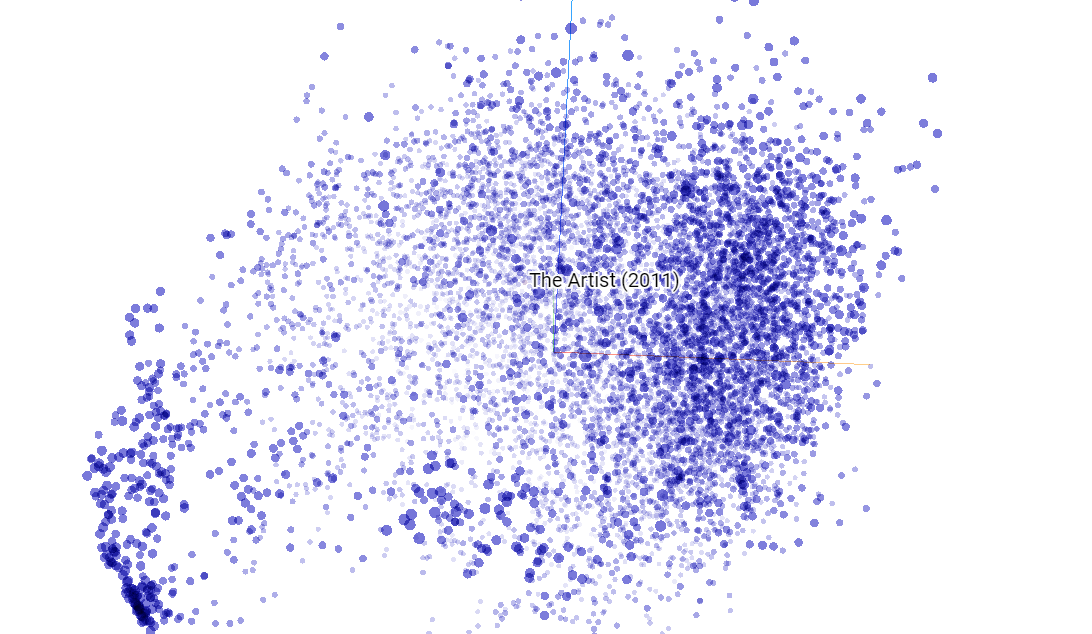

In [2]:
from IPython.display import display, Image
display(Image(filename='Capture.PNG'))

## Hyperparameters matter when using Word2Vec for Item recommendation:


> Skip-gram with negative sampling, a popular variant of Word2vec originally designed and tuned to create word embeddings for Natural Language Processing, has been used to create item embeddings with successful applications in recommendation. While these fields do not share the same type of data, neither evaluate on the same tasks, recommendation applications tend to use the same already tuned hyperparameters values, even if optimal hyperparameters values are often known to be data and task dependent. We thus investigate the marginal importance of each hyperparameter in a recommendation setting through large hyperparameter grid searches on various datasets. Results reveal that optimizing neglected hyperparameters, namely negative sampling distribution, number of epochs, subsampling parameter and window-size, significantly improves performance on a recommendation task, and can increase it by an order of magnitude. Importantly, we find that optimal hyperparameters configurations for Natural Language Processing tasks and Recommendation tasks are noticeably different. 

[Hyperparameters matter](https://arxiv.org/abs/1804.04212)

#### It turns out that  hyperparameters are really important for this task: especially the sampling parameter.  Try and learn multiple models to see how the ns_exponent parameter modifies the results:


In [27]:
# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=train_seq_str,
                                size=50, window=3,               ### here we train a cbow model 
                                min_count=0,                      
                                sample=0.001, ns_exponent=-0.4, workers=10,
                                sg=1, hs=0, negative=15,          ### set sg to 1 to train a sg model => Prod2Vec
                                cbow_mean=0,
                                iter=25)



2021-03-11 08:52:23,364 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2021-03-11 08:52:23,368 : INFO : collecting all words and their counts
2021-03-11 08:52:23,371 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-11 08:52:23,420 : INFO : collected 9616 word types from a corpus of 97786 raw words and 610 sentences
2021-03-11 08:52:23,422 : INFO : Loading a fresh vocabulary
2021-03-11 08:52:23,469 : INFO : effective_min_count=0 retains 9616 unique words (100% of original 9616, drops 0)
2021-03-11 08:52:23,471 : INFO : effective_min_count=0 leaves 97786 word corpus (100% of original 97786, drops 0)
2021-03-11 08:52:23,558 : INFO : deleting the raw counts dictionary of 9616 items
2021-03-11 08:52:23,559 : INFO : sample=0.001 downsamples 5 most-common words
2021-03-11 08:52:23,562 : INFO : downsampling leaves estimated 97657 word corpus (99.9% of prior 97786)
2021-03-11 08:52:23,639 : INFO : estimated required memory fo

2021-03-11 08:52:37,693 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:52:37,777 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:52:37,792 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:52:37,856 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:52:37,886 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:52:37,912 : INFO : EPOCH 7 - PROGRESS: at 84.43% examples, 77041 words/s, in_qsize 2, out_qsize 1
2021-03-11 08:52:37,916 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:52:37,982 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:52:37,997 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:52:38,000 : INFO : EPOCH - 7 : training on 97786 raw words (97672 effective words) took 1.1s, 88093 effective words/s
2021-03-11 08:52:38,423 : IN

2021-03-11 08:52:45,260 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:52:45,291 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:52:45,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-11 08:52:45,336 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-11 08:52:45,338 : INFO : EPOCH - 14 : training on 97786 raw words (97671 effective words) took 1.0s, 100488 effective words/s
2021-03-11 08:52:45,949 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:52:46,010 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:52:46,021 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:52:46,174 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:52:46,203 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:52:46,282 : INFO : worker thread 

2021-03-11 08:52:52,845 : INFO : EPOCH - 21 : training on 97786 raw words (97652 effective words) took 1.0s, 93588 effective words/s
2021-03-11 08:52:53,578 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-11 08:52:53,726 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-11 08:52:53,795 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-11 08:52:53,805 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-11 08:52:53,831 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-11 08:52:53,836 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-11 08:52:53,849 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-11 08:52:53,872 : INFO : EPOCH 22 - PROGRESS: at 86.07% examples, 76716 words/s, in_qsize 2, out_qsize 1
2021-03-11 08:52:53,874 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-11 08:52:53,914 : 

In [28]:
pop_preds = get_predictions(predict_pop,last_consumed_item,test_seq,-1)
w2v_preds = get_predictions(predict_w2v,last_consumed_item,test_seq,-1)

2021-03-11 08:52:58,840 : INFO : precomputing L2-norms of word weight vectors


In [29]:
print(1/mrr(pop_preds))
print(1/mrr(w2v_preds))

print(mean_dcg(pop_preds,5))
print(mean_dcg(w2v_preds,5))

print(mean_ndcg(pop_preds,5))
print(mean_ndcg(w2v_preds,5))

17.87234931650308
11.76756192559135
0.051054704276776476
0.09005718673541672
0.017315723982695277
0.03072274162984984


## Still got time ? Try making a more clever item selection mechanism:

- You could, for example, cluster items in groups (using k-means) and propose the most popular items of the last seen group